In [53]:
# Run this cell first
import os
import cv2
import json
import numpy as np
import torch
from pathlib import Path
from PIL import Image
from dotenv import load_dotenv
load_dotenv()
TEAM_NAME, TEAM_TRACK = os.getenv("TEAM_NAME"), os.getenv("TEAM_TRACK")
on_gcp = None not in [TEAM_NAME, TEAM_TRACK]

def display_image(source, annotations, title=None, title_colour=(0, 0, 0)):
    # annotations should be a list of dict { 'bbox': [l, t, w, h], 'caption': 'something' }
    colours = [(0, 255, 0), (0, 255, 255), (255, 0, 255)]
    n = min(len(colours), len(annotations))
    if isinstance(source, (str, Path)):
        image = cv2.imread(source)
    elif isinstance(source, np.ndarray):
        image = cv2.imdecode(source, cv2.IMREAD_COLOR)
    if title is not None:
        cv2.putText(image, title, (6, 32), cv2.FONT_HERSHEY_SIMPLEX, 1, title_colour, 2)
    for i, annotation in enumerate(annotations):
        l, t, w, h = annotation["bbox"]
        cv2.rectangle(image, (l, t), (l+w, t+h), colours[i % n], 2)
        caption = None
        if "caption" in annotation:
            caption = annotation["caption"]
        elif "class" in annotation:
            caption = annotation["class"]
        if caption is not None:
            cv2.putText(image, caption, (l, max(0, t-6)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, colours[i % n], 2)
    if on_gcp:
        display(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))
    else:
        Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)).show()

### Truth bounding box
Shows the actual bounding boxes of all objects in an image from the test dataset.

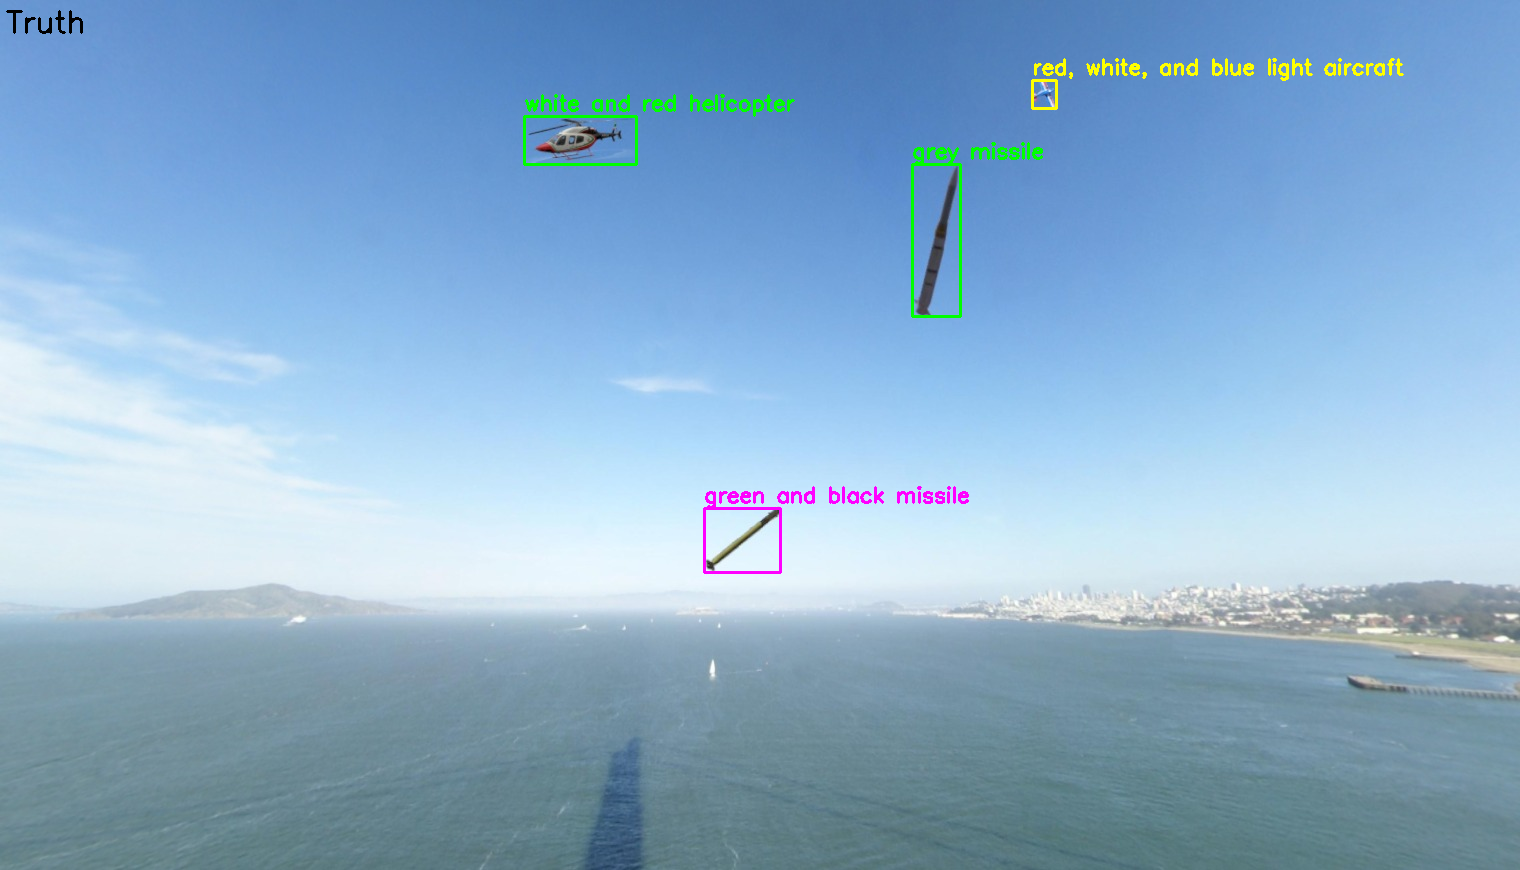

In [39]:
# View bounding box for image based on vlm.jsonl
# Set image number here
image_no = 0
if on_gcp:
    img_path = Path(f"/home/jupyter/advanced/images/image_{image_no}.jpg")
    jsonl = Path("/home/jupyter/advanced/vlm.jsonl")
else:
    img_path = Path(f"advanced/images/image_{image_no}.jpg")
    jsonl = Path("advanced/vlm.jsonl")
with open(jsonl) as f:
    for i, line in enumerate(f):
        if i == int(image_no):
            data = json.loads(line)
            break
        
display_image(img_path.as_posix(), data["annotations"], title="Truth")

### YOLOv8 Inference and Training

In [57]:
from ultralytics import YOLO
# YOLO_MODEL_NAME = "yolov8m.pt"
YOLO_MODEL_NAME = "vlm/models/yolov8m-finetuned-100/weights/best.pt"
yolo_model = YOLO(YOLO_MODEL_NAME)

# See yolov8/dataset.yaml for the full class mapping
class_id_to_name = yolo_model.names
def extract_caption_class(caption, return_name=False):
    # Extract the object's class from the caption
    if "aircraft" in caption:
        class_id = 80
    elif "drone" in caption:
        class_id = 81
    elif "helicopter" in caption:
        class_id = 82
    elif "fighter plane" in caption:
        class_id = 83
    elif "fighter jet" in caption:
        class_id = 84
    elif "missile" in caption:
        class_id = 85
    else:
        print(f"Unknown class for caption: {caption}")
        return None
    return class_id_to_name[class_id] if return_name else class_id


image 1/1 /home/jupyter/advanced/images/image_1.jpg: 384x640 1 aircraft, 1 drone, 1 fighter plane, 2 fighter jets, 1 missile, 16.5ms
Speed: 3.6ms preprocess, 16.5ms inference, 11.7ms postprocess per image at shape (1, 3, 384, 640)
[806, 506, 68, 65] 80 aircraft
[1105, 510, 148, 47] 83 fighter plane
[355, 453, 50, 32] 81 drone
[544, 112, 39, 39] 85 missile
[401, 158, 50, 34] 84 fighter jet
[1109, 174, 66, 34] 84 fighter jet


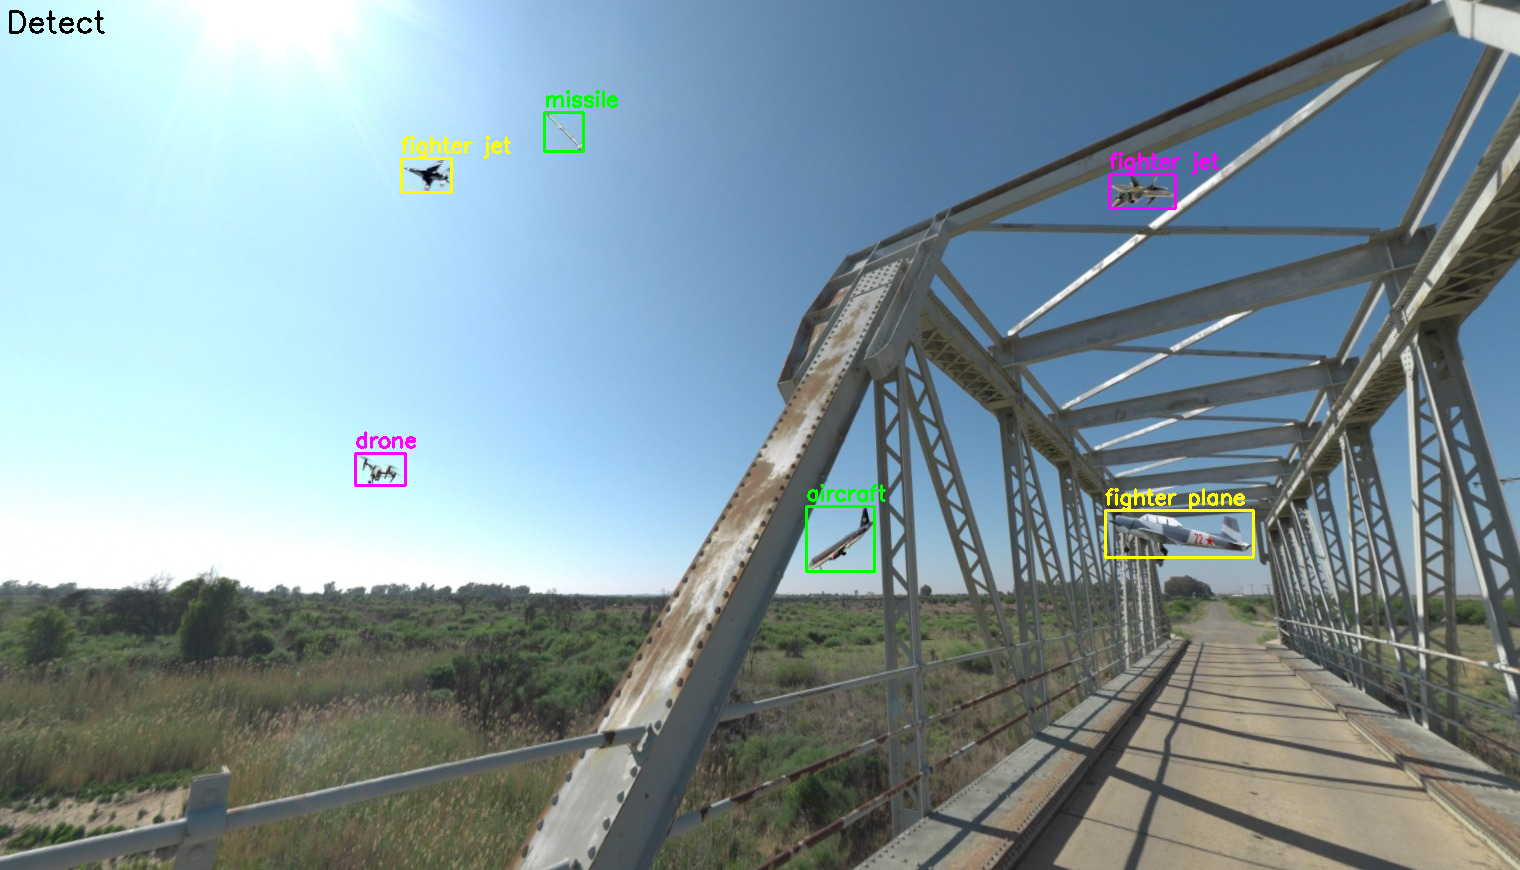

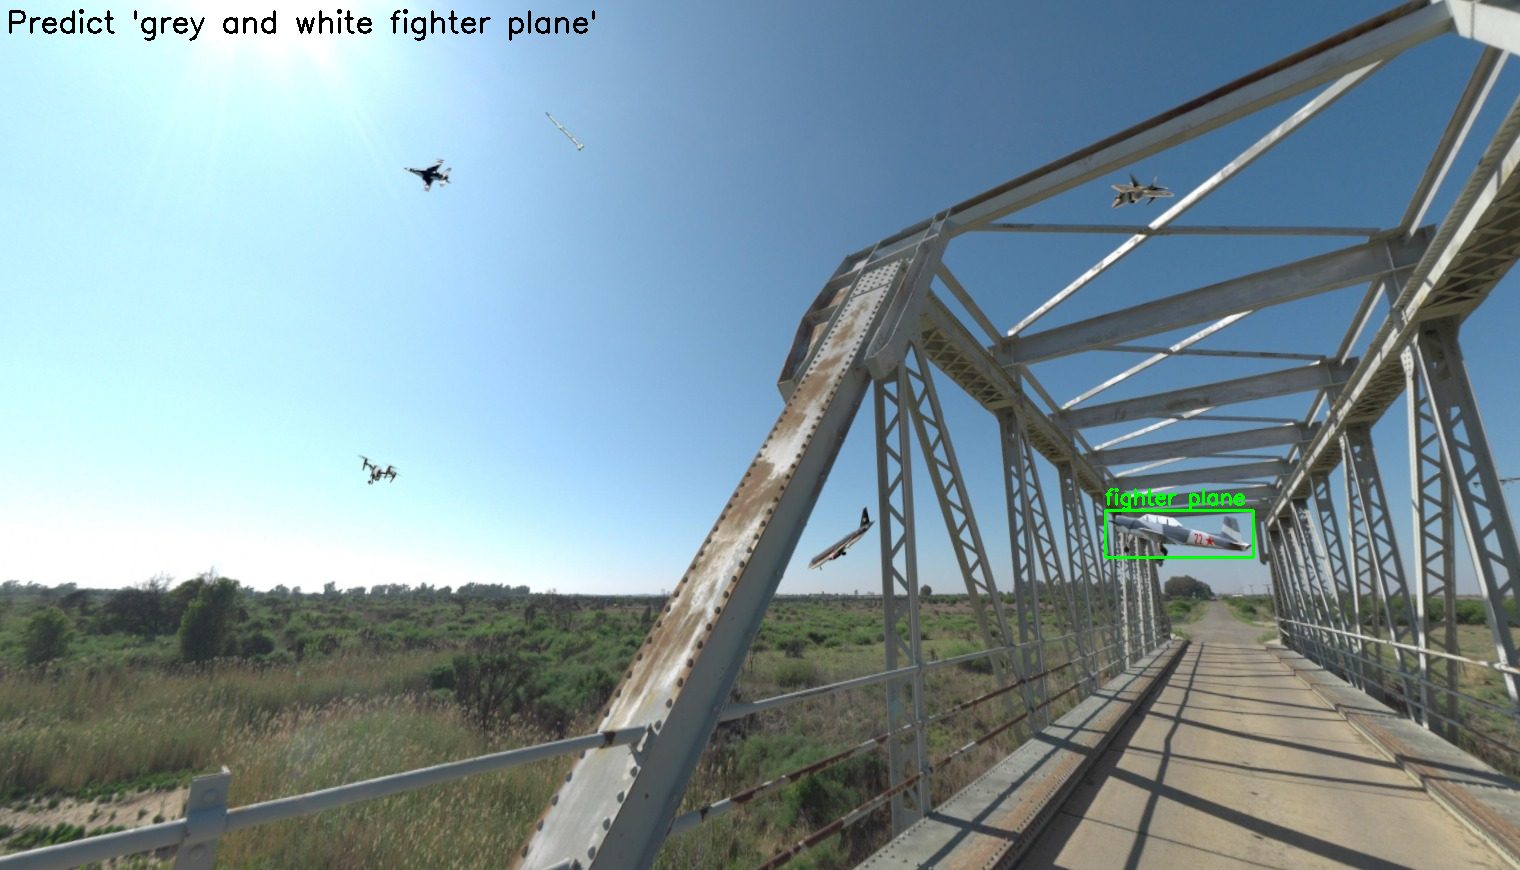

In [64]:
# Inference
image_no = 1
img_path = Path(f"{'/home/jupyter/' if on_gcp else ''}advanced/images/image_{image_no}.jpg")
yolo_result = yolo_model(img_path, half=True, conf=0.1)[0]
yolo_annotations = []

for box, cls in zip(yolo_result.boxes.xywh, yolo_result.boxes.cls):
    # Box is a Tensor of [x, y, w, h]
    x, y, w, h = box.tolist()
    # Crop bounding boxes from orginal image
    left, top, w, h = int(x-(w/2)), int(y-(h/2)), int(w), int(h)
    cropped = yolo_result.orig_img[top:top+h, left:left+w, ::-1] # BGR to RGB
    obj_class = class_id_to_name[cls.item()]
    print(f"[{left}, {top}, {int(w)}, {int(h)}] {cls.int().item()} {obj_class}")
    yolo_annotations.append({"image": cropped, "bbox": [left, top, w, h], "class": f"{obj_class}"})

display_image(img_path.as_posix(), yolo_annotations, title="Detect")

# caption = "grey missile"
# caption = "green and black missile"
caption = "grey and white fighter plane"
if caption is not None:
    from transformers import CLIPProcessor, CLIPModel
    
    MODEL = "openai/clip-vit-base-patch32"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    clip_model = CLIPModel.from_pretrained(MODEL).to(device)
    clip_processor = CLIPProcessor.from_pretrained(MODEL)
    
    inputs = clip_processor(text=caption, images=[a["image"] for a in yolo_annotations], return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        outputs = clip_model(**inputs)
    logits_per_image = outputs.logits_per_image # image-text similarity score
    best_match_idx = logits_per_image.argmax(dim=0).item()

    display_image(img_path.as_posix(), [yolo_annotations[best_match_idx]], title=f"Predict '{caption}'")

In [8]:
# Training
CHKPT_MODEL_NAME = "yolov8m.pt"
print("Training from:", CHKPT_MODEL_NAME)
epoch = 100
chkp_steps = 20
yolo_model.train(data="datasets/yolov8/data.yaml",
                 epochs=epoch,
                 batch=-1,
                 save_period=chkp_steps,
                 imgsz=640,
                 project="vlm/models",
                 name=f"{CHKPT_MODEL_NAME[:-3]}-finetuned-{epoch}",
                 exist_ok=True)

Training from: yolov8m.pt
New https://pypi.org/project/ultralytics/8.2.18 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.8 🚀 Python-3.10.14 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 14918MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=datasets/yolov8/data.yaml, epochs=100, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=20, cache=False, device=None, workers=8, project=vlm/models, name=yolov8m-finetuned-100, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retin

train: Scanning /home/jupyter/til-24-siewsugar/datasets/yolov8/labels/train.cache... 4085 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4085/4085 [00:00<?, ?it/s]
val: Scanning /home/jupyter/til-24-siewsugar/datasets/yolov8/labels/val.cache... 1022 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1022/1022 [00:00<?, ?it/s]


Plotting labels to vlm/models/yolov8m-finetuned-100/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000111, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to vlm/models/yolov8m-finetuned-100
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.34G      1.143      2.365     0.8829        127        640: 100%|█████████▉| 255/256 [02:10<00:00,  2.00it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
      1/100      7.34G      1.143      2.361      0.883         58        640: 100%|██████████| 256/256 [02:11<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]

                   all       1022       5515      0.775      0.699      0.796      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.55G      1.048      1.012     0.8694         47        640: 100%|██████████| 256/256 [02:08<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.48it/s]

                   all       1022       5515      0.859      0.816      0.907      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.56G      1.016     0.8078     0.8577         60        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.36it/s]

                   all       1022       5515      0.901      0.856      0.934      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.65G     0.9943     0.7058     0.8555         23        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.46it/s]

                   all       1022       5515      0.924      0.872       0.95       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.64G     0.9633     0.6471     0.8479         60        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]

                   all       1022       5515      0.934      0.891      0.958      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.65G     0.9638     0.6123     0.8477         39        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.35it/s]

                   all       1022       5515      0.947      0.897      0.964      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.65G     0.9413     0.5777     0.8418         37        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.46it/s]

                   all       1022       5515      0.944      0.922      0.968        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.62G     0.9284     0.5585     0.8406         65        640: 100%|██████████| 256/256 [02:07<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.36it/s]

                   all       1022       5515      0.952      0.911       0.97      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.63G     0.9236      0.539      0.839         69        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.34it/s]

                   all       1022       5515      0.945      0.931      0.975      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.64G     0.9121     0.5203     0.8361         35        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]

                   all       1022       5515      0.942      0.923      0.972      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.63G     0.9023     0.5062     0.8333         55        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]

                   all       1022       5515      0.956      0.932      0.979      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.63G      0.888     0.4941     0.8337         44        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.33it/s]

                   all       1022       5515      0.963      0.938       0.98      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.59G     0.8922     0.4879     0.8331         51        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.48it/s]

                   all       1022       5515      0.966      0.945      0.981       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.63G     0.8857     0.4803     0.8289         61        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.50it/s]

                   all       1022       5515       0.97      0.938      0.982      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.66G     0.8708     0.4676     0.8287         50        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.30it/s]

                   all       1022       5515      0.969      0.938      0.981      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.62G     0.8719     0.4655     0.8279         46        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.48it/s]

                   all       1022       5515      0.967      0.941      0.982      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.62G     0.8667     0.4608     0.8272         28        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]

                   all       1022       5515      0.969       0.94      0.983      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.66G     0.8508     0.4465     0.8268         47        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]

                   all       1022       5515      0.976      0.945      0.985      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.64G     0.8486     0.4452     0.8254         34        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]

                   all       1022       5515      0.972      0.944      0.984      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       7.6G      0.838     0.4349     0.8243         38        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.46it/s]

                   all       1022       5515      0.972      0.937      0.982      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.66G     0.8428     0.4374     0.8246         68        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.46it/s]

                   all       1022       5515      0.972      0.943      0.982      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.64G     0.8357     0.4276     0.8217         36        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.44it/s]

                   all       1022       5515      0.979      0.952      0.986      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       7.6G     0.8268     0.4219     0.8226         44        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.45it/s]

                   all       1022       5515      0.977      0.951      0.984       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.65G     0.8251     0.4207     0.8206         42        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]

                   all       1022       5515      0.977      0.948      0.985      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.64G     0.8174      0.413     0.8195         52        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.50it/s]

                   all       1022       5515      0.968      0.956      0.985       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.63G     0.8193     0.4146     0.8171         68        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]

                   all       1022       5515       0.97      0.956      0.986      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       7.6G     0.8083     0.4084     0.8181         34        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.30it/s]

                   all       1022       5515      0.973      0.953      0.986      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.62G     0.8128     0.4095     0.8175         32        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]

                   all       1022       5515      0.975      0.944      0.984      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100       7.6G     0.8073     0.4046     0.8197         40        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.44it/s]

                   all       1022       5515       0.97      0.953      0.983      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.59G     0.7972     0.3995     0.8181         67        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.28it/s]

                   all       1022       5515      0.975      0.956      0.986      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.65G     0.7939     0.3933     0.8169         74        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]

                   all       1022       5515      0.974      0.956      0.985      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.63G     0.7886     0.3954     0.8161         47        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]

                   all       1022       5515       0.98      0.948      0.984      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.63G     0.7885     0.3914     0.8153         45        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.22it/s]

                   all       1022       5515      0.974      0.954      0.985      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.63G     0.7776     0.3849     0.8156         67        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.46it/s]

                   all       1022       5515      0.978      0.948      0.983      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.59G     0.7764     0.3867     0.8126         40        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.41it/s]

                   all       1022       5515      0.974      0.952      0.984      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.64G     0.7771     0.3823     0.8136         62        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.39it/s]

                   all       1022       5515      0.982      0.946      0.984      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.62G     0.7727     0.3804     0.8123         54        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.49it/s]

                   all       1022       5515      0.978      0.949      0.984       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       7.6G     0.7701      0.379     0.8126         55        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.49it/s]

                   all       1022       5515      0.974      0.954      0.984       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.63G     0.7638     0.3748     0.8131         48        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.37it/s]

                   all       1022       5515       0.98      0.947      0.984      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       7.6G     0.7558     0.3712     0.8112         64        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.49it/s]

                   all       1022       5515      0.981      0.954      0.986      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.64G     0.7499     0.3664     0.8117         42        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]

                   all       1022       5515      0.974      0.955      0.984      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.63G     0.7496      0.367     0.8103         52        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.37it/s]

                   all       1022       5515      0.977      0.951      0.984      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.63G     0.7455     0.3639     0.8105         39        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.41it/s]

                   all       1022       5515       0.98      0.951      0.985      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.65G     0.7428     0.3643      0.808         54        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.46it/s]

                   all       1022       5515      0.979      0.952      0.985      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.59G      0.737      0.359      0.809         39        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.38it/s]

                   all       1022       5515      0.974      0.955      0.985       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.59G     0.7301     0.3579     0.8082         35        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.44it/s]

                   all       1022       5515      0.979      0.946      0.983       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       7.6G     0.7262     0.3517      0.808         36        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]

                   all       1022       5515      0.984      0.949      0.986      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.62G     0.7245     0.3516     0.8074         32        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.38it/s]

                   all       1022       5515      0.978      0.954      0.985      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       7.6G     0.7245      0.353     0.8053         62        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.48it/s]

                   all       1022       5515      0.976      0.955      0.986      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.61G     0.7128     0.3475     0.8056         44        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.49it/s]

                   all       1022       5515      0.977      0.955      0.983      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.66G     0.7132      0.345     0.8048         61        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.39it/s]

                   all       1022       5515      0.978      0.953      0.985      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.65G     0.7113     0.3448     0.8068         39        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.44it/s]

                   all       1022       5515       0.98      0.948      0.984      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.59G     0.7041     0.3409     0.8055         47        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.36it/s]

                   all       1022       5515      0.984      0.948      0.984      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       7.6G     0.7028     0.3406     0.8039         46        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.38it/s]

                   all       1022       5515      0.978      0.952      0.985      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.65G     0.6977     0.3394     0.8056         75        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.46it/s]

                   all       1022       5515      0.977      0.955      0.985      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.64G     0.6893     0.3342      0.804         30        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.46it/s]

                   all       1022       5515      0.983      0.952      0.984      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       7.6G     0.6859     0.3325      0.803         17        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.27it/s]

                   all       1022       5515      0.985       0.95      0.984      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.64G     0.6806     0.3278     0.8029         71        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]

                   all       1022       5515      0.978      0.955      0.985      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.63G     0.6782     0.3272     0.8012         51        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]

                   all       1022       5515       0.98      0.953      0.986      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.68G     0.6756     0.3265     0.8016         57        640: 100%|██████████| 256/256 [02:13<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.21it/s]

                   all       1022       5515      0.981      0.954      0.984      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       7.6G     0.6696     0.3257     0.8006         44        640: 100%|██████████| 256/256 [02:12<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.44it/s]

                   all       1022       5515      0.983      0.954      0.985      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.67G     0.6694     0.3242     0.8016         58        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]

                   all       1022       5515       0.98      0.954      0.985      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.63G     0.6604     0.3214     0.8008         88        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]

                   all       1022       5515      0.983      0.955      0.985      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.56G      0.656     0.3178     0.7989         35        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]

                   all       1022       5515      0.985      0.952      0.985      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.66G     0.6541     0.3184        0.8         38        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.49it/s]

                   all       1022       5515      0.985      0.952      0.986      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.64G     0.6531      0.319        0.8         35        640: 100%|██████████| 256/256 [02:19<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.29it/s]

                   all       1022       5515      0.977      0.957      0.986      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.65G     0.6507     0.3157     0.7993         39        640: 100%|██████████| 256/256 [02:07<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.45it/s]

                   all       1022       5515      0.976      0.956      0.985      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.66G     0.6414     0.3124     0.7988         47        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.36it/s]

                   all       1022       5515       0.98      0.956      0.986      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.64G     0.6425     0.3117     0.7984         31        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.50it/s]

                   all       1022       5515      0.978      0.961      0.985      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.65G     0.6351     0.3086     0.7979         68        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]

                   all       1022       5515      0.977      0.962      0.986      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.59G     0.6391     0.3094     0.7988         59        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.48it/s]

                   all       1022       5515       0.98       0.95      0.984      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.65G      0.625     0.3048     0.7963         55        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]

                   all       1022       5515      0.979      0.956      0.985      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.59G     0.6242      0.304     0.7958         50        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]

                   all       1022       5515       0.98      0.952      0.985      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.63G       0.62     0.3032     0.7942         64        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.44it/s]

                   all       1022       5515      0.976      0.957      0.985      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.64G     0.6162     0.3001     0.7957         28        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.37it/s]

                   all       1022       5515      0.979      0.958      0.985      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.65G     0.6149     0.3007     0.7947         41        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.36it/s]

                   all       1022       5515       0.98      0.956      0.986       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       7.6G     0.6095     0.2961     0.7962         54        640: 100%|██████████| 256/256 [02:07<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.46it/s]

                   all       1022       5515       0.98      0.955      0.985      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.59G     0.6072     0.2946     0.7943         40        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]

                   all       1022       5515      0.979      0.957      0.985      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.62G     0.6026      0.294     0.7939         44        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.48it/s]

                   all       1022       5515      0.982      0.954      0.985      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.63G     0.5974     0.2921     0.7958         39        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]

                   all       1022       5515       0.98      0.957      0.985      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.59G     0.5998     0.2916     0.7939         58        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.46it/s]

                   all       1022       5515      0.977      0.958      0.984      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.59G     0.5938     0.2887     0.7936         59        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.34it/s]

                   all       1022       5515      0.982      0.954      0.985      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.59G     0.5896     0.2883      0.794         44        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]

                   all       1022       5515      0.981      0.957      0.986      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       7.6G     0.5857      0.286     0.7915         41        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]

                   all       1022       5515       0.98      0.956      0.985      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.59G     0.5821     0.2846     0.7929         68        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]

                   all       1022       5515       0.98      0.956      0.986      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.64G     0.5842     0.2859     0.7931         38        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.49it/s]

                   all       1022       5515      0.981      0.956      0.986      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.64G     0.5758     0.2827     0.7928         57        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.35it/s]

                   all       1022       5515      0.978      0.959      0.986       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.65G     0.5817     0.2842     0.7918         39        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]

                   all       1022       5515       0.98      0.957      0.986      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.66G     0.5707     0.2777     0.7927         48        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.44it/s]

                   all       1022       5515      0.981      0.957      0.986      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.62G     0.5698     0.2801      0.791         55        640: 100%|██████████| 256/256 [02:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.37it/s]

                   all       1022       5515      0.983      0.954      0.986      0.757


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.55G     0.5626     0.2616     0.7902         32        640: 100%|██████████| 256/256 [02:08<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.45it/s]

                   all       1022       5515       0.98      0.957      0.985       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.56G     0.5244     0.2496     0.7866         32        640: 100%|██████████| 256/256 [02:06<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.41it/s]

                   all       1022       5515      0.978      0.958      0.985      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.56G     0.5236     0.2478     0.7868         24        640: 100%|██████████| 256/256 [02:06<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.35it/s]

                   all       1022       5515      0.983      0.955      0.985      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.54G     0.5204     0.2475     0.7857         27        640: 100%|██████████| 256/256 [02:06<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]

                   all       1022       5515      0.981      0.956      0.986      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.55G     0.5149     0.2445     0.7851         34        640: 100%|██████████| 256/256 [02:06<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.27it/s]

                   all       1022       5515      0.983      0.956      0.986      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.54G     0.5109     0.2427     0.7852         22        640: 100%|██████████| 256/256 [02:06<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.36it/s]

                   all       1022       5515      0.985      0.955      0.986      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.56G     0.5113     0.2437     0.7869         32        640: 100%|██████████| 256/256 [02:08<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.05it/s]

                   all       1022       5515      0.985      0.954      0.986      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      7.55G     0.5009     0.2377     0.7846         24        640: 100%|██████████| 256/256 [02:08<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.28it/s]

                   all       1022       5515      0.984      0.955      0.986      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.54G     0.5016     0.2407     0.7847         29        640: 100%|██████████| 256/256 [02:06<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.41it/s]

                   all       1022       5515      0.981      0.957      0.986      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.55G     0.4965      0.237      0.783         33        640: 100%|██████████| 256/256 [02:06<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.45it/s]

                   all       1022       5515      0.982      0.957      0.986      0.793



100 epochs completed in 3.892 hours.
Optimizer stripped from vlm/models/yolov8m-finetuned-100/weights/last.pt, 52.1MB
Optimizer stripped from vlm/models/yolov8m-finetuned-100/weights/best.pt, 52.1MB

Validating vlm/models/yolov8m-finetuned-100/weights/best.pt...
Ultralytics YOLOv8.2.8 🚀 Python-3.10.14 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 14918MiB)
Model summary (fused): 218 layers, 25889554 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


                   all       1022       5515      0.984      0.955      0.986      0.794
              aircraft       1022       1652      0.978      0.975      0.992      0.821
                 drone       1022        382      0.988      0.927      0.978      0.769
            helicopter       1022       1072      0.985      0.961      0.981      0.774
         fighter plane       1022       1013      0.982      0.961      0.988      0.803
           fighter jet       1022        767      0.987       0.95      0.987      0.795
               missile       1022        629      0.987      0.954      0.991      0.803
Speed: 0.1ms preprocess, 5.4ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to vlm/models/yolov8m-finetuned-100


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([80, 81, 82, 83, 84, 85])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fc934ef9540>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,

### YOLOv8 Training Data Generation and Analysis on vlm.jsonl

In [3]:
from tqdm import tqdm

if on_gcp:
    # For running on GCP
    input_dir = Path(f"/home/jupyter/{TEAM_TRACK}")
    results_dir = Path(f"/home/jupyter/{TEAM_NAME}")
else:
    # For running locally
    input_dir = Path("advanced")
    results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)

truths = []
with open(input_dir / "vlm.jsonl", "r") as f:
    for line in tqdm(f, desc="Reading vlm.jsonl"):
        if line.strip() == "":
            continue
        instance = json.loads(line.strip())
        for annotation in instance["annotations"]:
            truths.append(
                {
                    "image": instance["image"],
                    "caption": annotation["caption"],
                    "bbox": annotation["bbox"],
                }
            )

Reading vlm.jsonl: 5107it [00:00, 31812.45it/s]


In [5]:
# Generate training dataset for YOLOv8
from itertools import groupby
import shutil
import random

OUT_IMG_DIR = Path("datasets/yolov8/images")
OUT_LBL_DIR = Path("datasets/yolov8/labels")
OUT_IMG_TRN_DIR, OUT_LBL_TRN_DIR = OUT_IMG_DIR / "train", OUT_LBL_DIR / "train"
OUT_IMG_VAL_DIR, OUT_LBL_VAL_DIR = OUT_IMG_DIR / "val", OUT_LBL_DIR / "val"
TRAIN_TEST_SPLIT = 0.8
JPG_RESOLUTION = (1520, 870)
os.makedirs(OUT_IMG_TRN_DIR, exist_ok=True)
os.makedirs(OUT_LBL_TRN_DIR, exist_ok=True)
os.makedirs(OUT_IMG_VAL_DIR, exist_ok=True)
os.makedirs(OUT_LBL_VAL_DIR, exist_ok=True)

# Shuffle and split the dataset into training and testing
images_annotations = {}
for image_file, annotations in groupby(truths, key=lambda x: x["image"]):
    images_annotations[image_file] = list(annotations)
all_images = list(images_annotations.keys())
random.shuffle(all_images)
split_index = int(len(all_images) * TRAIN_TEST_SPLIT)
train_images = all_images[:split_index]
test_images = all_images[split_index:]

def save_yolo_dataset(images, images_dir, labels_dir):
    for image_file in tqdm(images, total=len(images), desc="Processing dataset images"):
        image_path = input_dir / "images" / image_file
        if not image_path.exists():
            print(f"The file {image_file} does not exist.")
            continue

        # For every image, create a text file with the bounding box annotations
        # Format: class x_center y_center width height
        labels = []
        for anno in images_annotations[image_file]:
            # Convert l, t, w, h to x_center, y_center, w, h
            l, t, w, h = anno["bbox"]
            x = (l + w // 2) / JPG_RESOLUTION[0]
            y = (t + h // 2) / JPG_RESOLUTION[1]
            w /= JPG_RESOLUTION[0]
            h /= JPG_RESOLUTION[1]

            # Extract the object's class from the caption
            class_id = extract_caption_class(anno["caption"])
            if class_id is None:
                print(f"Unknown class for caption {anno['caption']} ({anno['image']})")
                continue

            labels.append(f"{class_id} {x} {y} {w} {h}\n")

        # Write the labels to file
        with open(labels_dir / f"{anno['image'][:-4]}.txt", "w") as f:
            f.writelines(labels)

        # Copy the image to the training directory
        shutil.copy(image_path, images_dir)

save_yolo_dataset(train_images, OUT_IMG_TRN_DIR, OUT_LBL_TRN_DIR)
save_yolo_dataset(test_images, OUT_IMG_VAL_DIR, OUT_LBL_VAL_DIR)

Processing dataset images: 100%|██████████| 1022/1022 [00:24<00:00, 42.33it/s]


In [10]:
# List the most common words from the captions
import pandas as pd
from collections import Counter

words_generator = (truth["caption"].split() for truth in truths)
word_freq = Counter(word.replace(',', '') for words in words_generator for word in words)
word_freq.pop("and")
df = pd.DataFrame(word_freq.most_common(), columns=["word", "freq"])
print(df.to_string(index=False))

      word  freq
     white 10598
   fighter  9443
  aircraft  8290
     black  7058
       red  6294
      blue  6240
      grey  5906
     plane  5364
helicopter  5309
    yellow  5148
     green  4463
       jet  4079
     light  3474
commercial  3163
   missile  2914
camouflage  2162
     drone  1957
     cargo  1653
    orange  1220
     brown   956
    silver   483
